# 目的
Kerasを用いた為替の予測をもう少し進める。   

In [6]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers import LSTM
from keras.callbacks import EarlyStopping
from keras.models import model_from_json
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

import os
import pickle
import pandas as pd
import numpy as np

from FX.FX import SQLAnaforFX
from FX.FX import drawfigfunc as dff
from FX.FX import analyzefuncs as af
# from FX.FX import downloadFXdata as dFX

## データの用意

In [10]:
"""DBの読み込み"""
dbpath = "201704"
sql = SQLAnaforFX(dbpath)
sql.showtablenames()

"""OHLC"""
close = sql.toDataFrame("ask01min", colselect=["close"]).as_matrix()[:,0]
opens = sql.toDataFrame("ask01min", colselect=["open"]).as_matrix()[:,0]
high = sql.toDataFrame("ask01min", colselect=["high"]).as_matrix()[:,0]
low = sql.toDataFrame("ask01min", colselect=["low"]).as_matrix()[:,0]
ohlc = np.vstack((opens, high, low, close))

dclose = np.zeros_like(close)
dclose[1:] = np.diff(close)

"""Spread"""
close_bid = sql.toDataFrame("bid01min", colselect=["close"]).as_matrix()[:,0]
s = np.mean((close - close_bid)[close != 0])

"""SMA"""
sma = sql.toDataFrame("ask01min", colselect=["sma07", "sma13", "sma25"]).as_matrix()
sma = sma.T

In [12]:
len(sql.toDataFrame())

322762

In [13]:
len(sql.toDataFrame())/len(close)

12.120695482368847

# スプレッドがゼロだとどうなるか

In [14]:
def create_model(X, y):
    model = Sequential()
    
    # 入力層
    model.add(Dense(256, input_shape=(X.shape[1],)))
    model.add(Activation('relu'))
    model.add(Dropout(0.3))

    # 中間層
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dropout(0.3))

    # 出力層
    model.add(Dense(y.shape[1]))
    model.add(Activation('softmax'))

    # コンパイル
    model.compile(loss='categorical_crossentropy',
        optimizer="rmsprop",
        metrics=['accuracy'])
    
    return model

In [15]:
y = af.labeling(close, 0.0, 30, 2)

close_norm = close - close.mean()
X = close_norm / np.abs(close_norm).max()
X_train, X_test, y_train, y_test = train_test_split(X[:, None], y, test_size=0.3, random_state=90)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

model = create_model(X[:, None], y)

(18640, 1) (7989, 1) (18640, 3) (7989, 3)


In [23]:
# データで訓練 --- (※5)
hist = model.fit(
    X_train, y_train,
    batch_size=100,
    epochs=80,
    validation_split=0.1,
    callbacks=[EarlyStopping(monitor='val_loss', patience=2)],
    verbose=0)

# テストデータを用いて評価する --- (※6)
score = model.evaluate(X_test, y_test, verbose=0)
print('loss=', score[0])
print('accuracy=', score[1])

loss= 0.896097823241
accuracy= 0.496933283339


## もし高確率で予測されるもののみを取り出したら、正解率はどうなる？

まずは確率のヒストグラムをとる。

In [25]:
"""確率の取得"""
probs = model.predict_proba(X_test, verbose=0).T
labels = ["high", "lose", "low"]

"""確率のヒストグラムの作成"""
xbins = np.arange(0, 1.0, 0.05)
hists = np.zeros((3, len(xbins)))
for ii in range(len(probs)):
    hists[ii, :-1], bins = np.histogram(probs[ii], bins=xbins)
    hists[ii] /= hists[ii].sum()

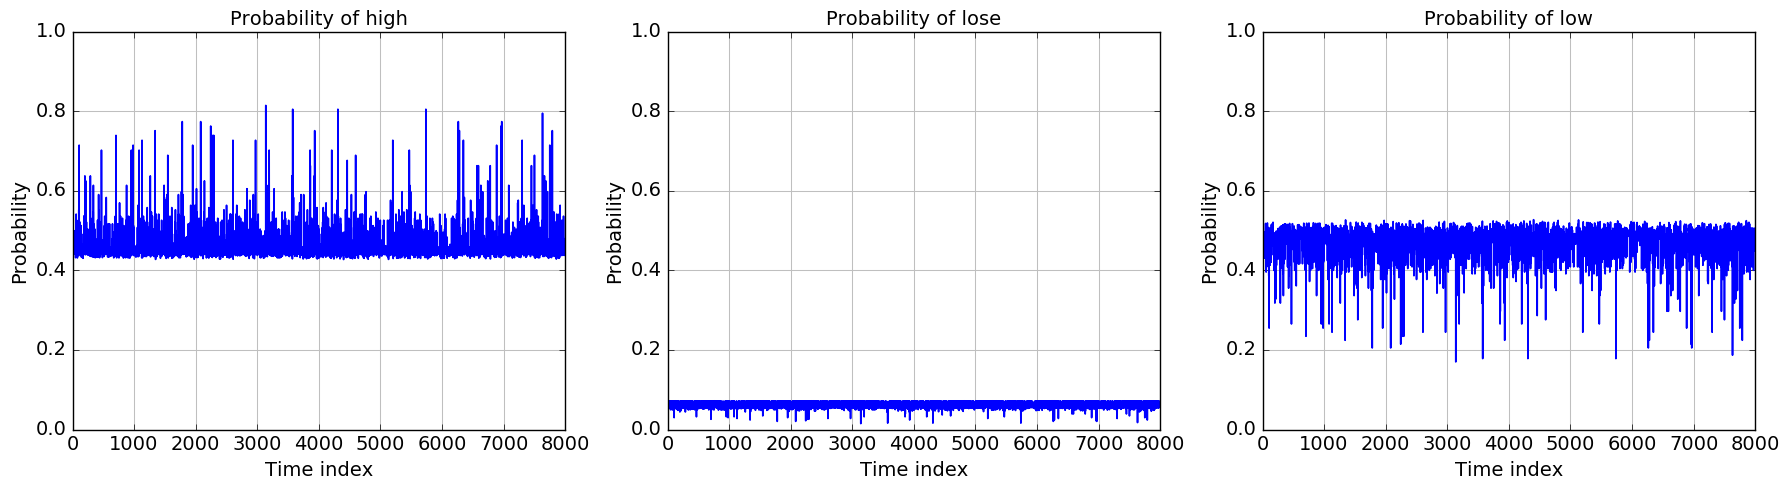

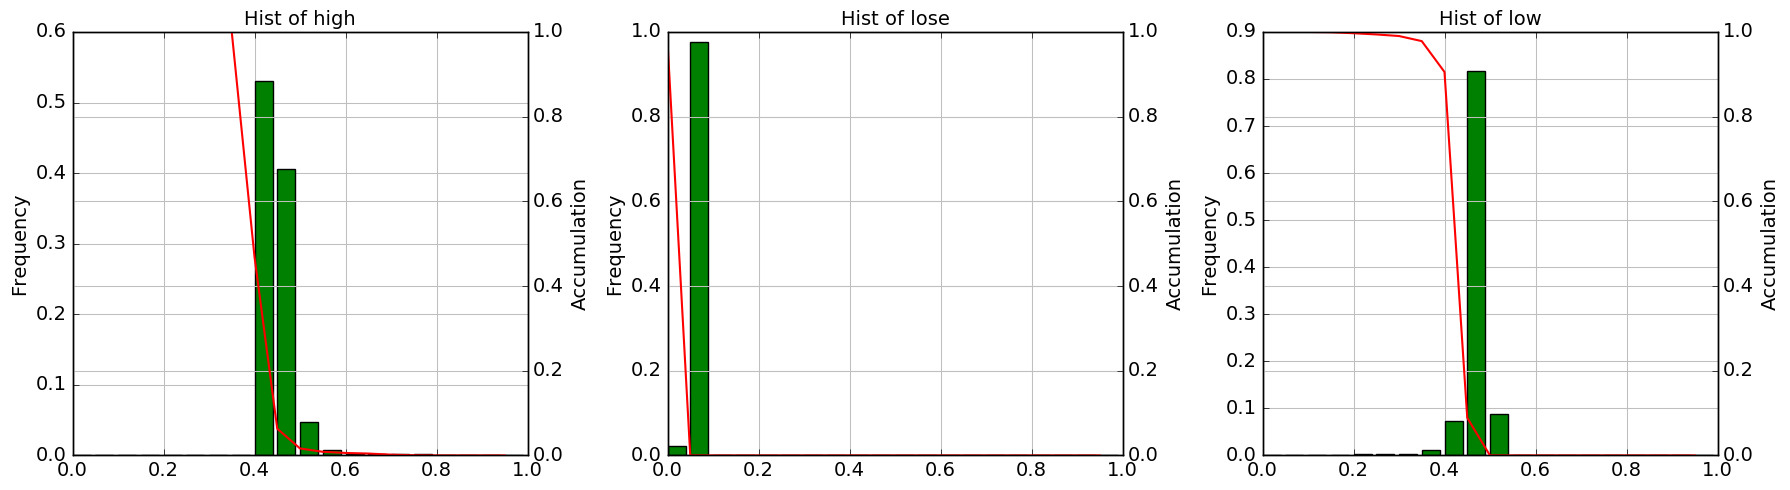

In [26]:
# 各ラベルに該当する確率
dff.makefig(18, 5)
for ii in range(len(probs)):
    plt.subplot(1,3,ii + 1)
    plt.plot(probs[ii], linewidth=1.2)
    dff.arrangefig(xlabel="Time index", ylabel="Probability", title="Probability of {}".format(labels[ii]))
    plt.ylim(0, 1)
plt.tight_layout()

# 各ラベルに該当する確率のヒストグラム
dff.makefig(18, 5)
dxbins = np.diff(xbins)[0]
for ii in range(len(hists)):
    plt.subplot(1,3,ii + 1)
    plt.bar(xbins, hists[ii], width=0.8*dxbins, hold="center", color="g")
    dff.arrangefig(ylabel="Frequency")
    ax2 = plt.gca().twinx()
    ax2.plot(xbins, 1.0 - np.cumsum(hists[ii]), "r-", linewidth=1.5)
    dff.arrangefig(xlabel="Probability", ylabel="Accumulation", title="Hist of {}".format(labels[ii]))
    plt.ylim(0, 1)
#     plt.yscale("log")
plt.tight_layout()

とりあえず60%以上を対象にするか。

In [27]:
prob_threshold = 0.6
probs = model.predict_proba(X_test, verbose=0).T
inds = np.zeros_like(probs, dtype=bool)
for ii in range(0, probs.shape[0]):
    inds[ii] = probs[ii] >= prob_threshold
ind_sum = inds.sum(axis=0) > 0
print("<# of events over threshold>")
print("[high, lose, low]:", inds.sum(axis=1), ",total:", ind_sum.sum())

# # テストデータを用いて評価する --- (※6)
score = model.evaluate(X_test[ind_sum], y_test[ind_sum], verbose=0)
print('loss=', score[0])
print('accuracy=', score[1])

<# of events over threshold>
[high, lose, low]: [69  0  0] ,total: 69
loss= 0.576351141152
accuracy= 0.768115942029


おや？案外確率は高いのでは？

# SMAを利用した場合

In [28]:
def create_model(X, y):
    model = Sequential()
    
    # 入力層
    model.add(Dense(256, input_shape=(X.shape[1],)))
    model.add(Activation('relu'))
    model.add(Dropout(0.3))

    # 中間層
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dropout(0.3))

    # 出力層
    model.add(Dense(y.shape[1]))
    model.add(Activation('softmax'))

    # コンパイル
    model.compile(loss='categorical_crossentropy',
        optimizer="rmsprop",
        metrics=['accuracy'])
    
    return model

In [41]:
y = af.labeling(close, 2*s, 30, 2)

sma_mean = sma.mean(axis=1)
sma_norm = np.zeros_like(sma)
for ii in range(sma.shape[0]):
    sma_norm[ii] = sma[ii] - sma_mean[ii]
    sma_norm[ii] /= np.abs(sma_norm[ii]).max()

X = sma_norm.T
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=8)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

model = create_model(X, y)

(18640, 3) (7989, 3) (18640, 3) (7989, 3)


In [46]:
# データで訓練 --- (※5)
hist = model.fit(
    X_train, y_train,
    batch_size=100,
    epochs=160, shuffle=False,
    validation_split=0.1,
    callbacks=[EarlyStopping(monitor='val_loss', patience=2)],
    verbose=0)

# テストデータを用いて評価する --- (※6)
score = model.evaluate(X_test, y_test, verbose=0)
print('loss=', score[0])
print('accuracy=', score[1])

loss= 0.922118726101
accuracy= 0.535986982175


内部で利用されている乱数の問題か？accuracyがfitのタイミングによって変わる。   
これは勘違いかもしれない。epochごとにmodel内でfitの結果が保持されており（当たり前だが）、
fitを回していくとさらにepochを追加したことになるため、fitの結果が更新されているだけか。

## こちらでも高確率のもののみを取り出す

In [47]:
"""確率の取得"""
probs = model.predict_proba(X_test, verbose=0).T
labels = ["high", "lose", "low"]

"""確率のヒストグラムの作成"""
xbins = np.arange(0, 1.0, 0.05)
hists = np.zeros((3, len(xbins)))
for ii in range(len(probs)):
    hists[ii, :-1], bins = np.histogram(probs[ii], bins=xbins)
    hists[ii] /= hists[ii].sum()

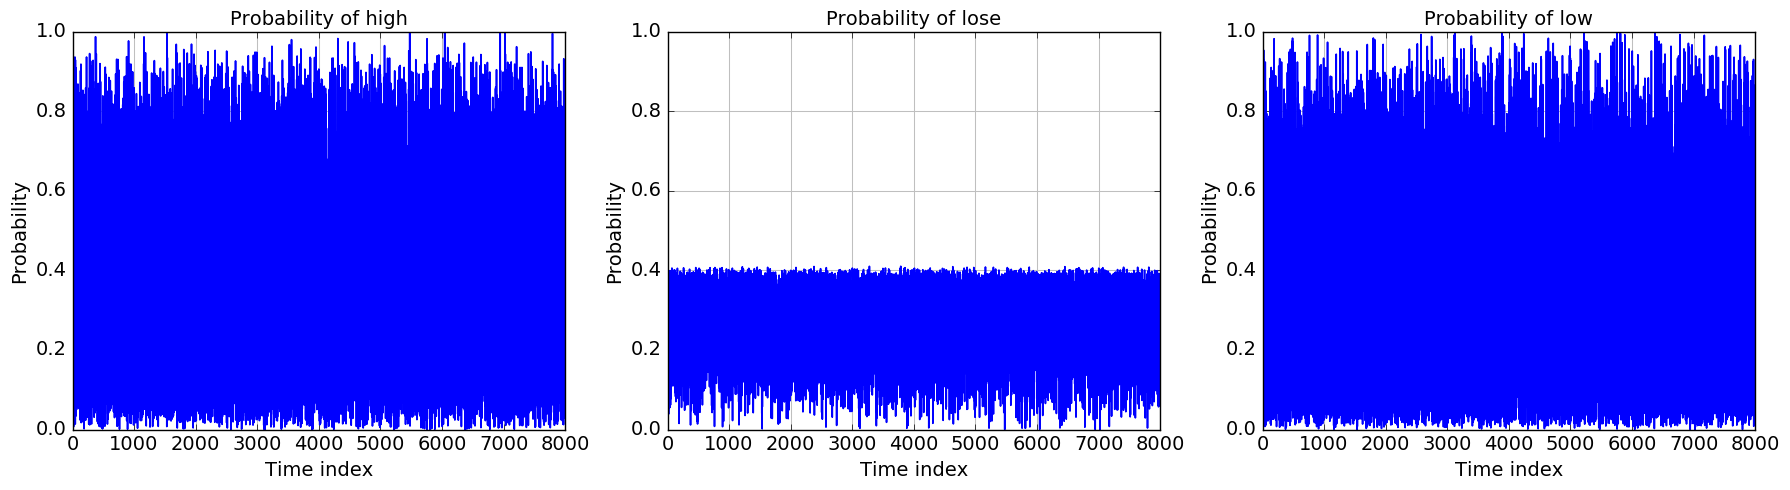

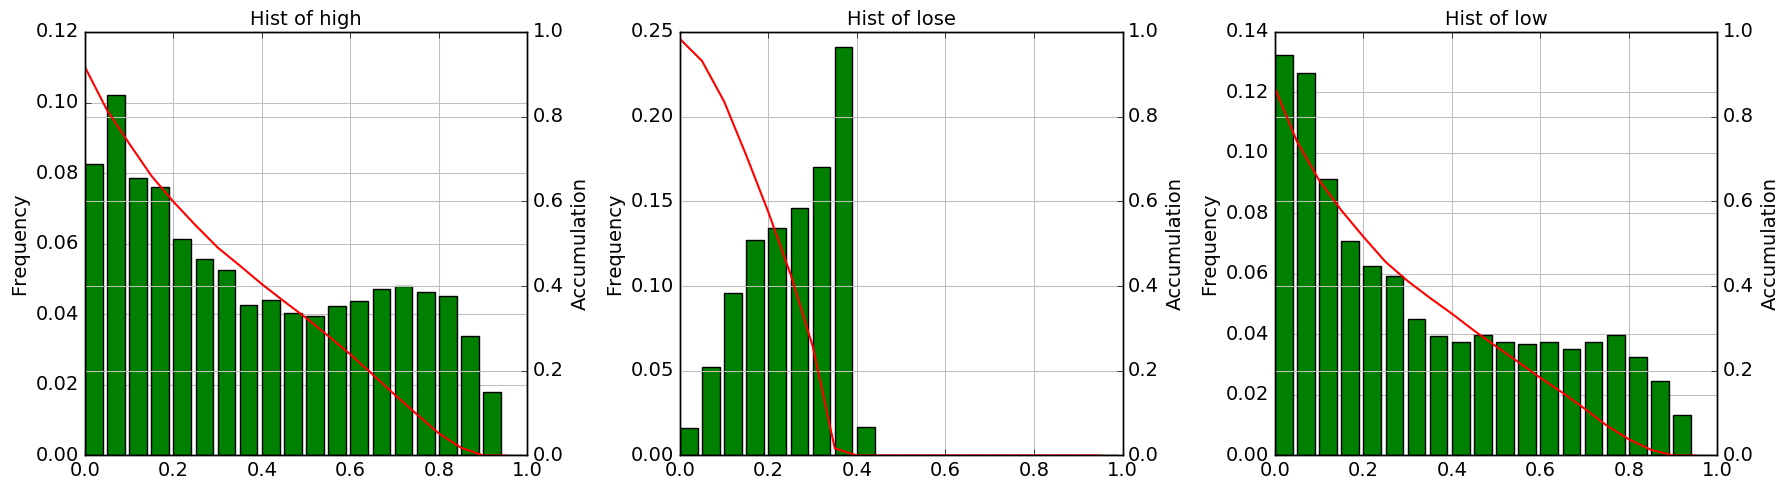

In [48]:
# 各ラベルに該当する確率
dff.makefig(18, 5)
for ii in range(len(probs)):
    plt.subplot(1,3,ii + 1)
    plt.plot(probs[ii], linewidth=1.2)
    dff.arrangefig(xlabel="Time index", ylabel="Probability", title="Probability of {}".format(labels[ii]))
    plt.ylim(0, 1)
plt.tight_layout()

# 各ラベルに該当する確率のヒストグラム
dff.makefig(18, 5)
dxbins = np.diff(xbins)[0]
for ii in range(len(hists)):
    plt.subplot(1,3,ii + 1)
    plt.bar(xbins, hists[ii], width=0.8*dxbins, hold="center", color="g")
    dff.arrangefig(ylabel="Frequency")
    ax2 = plt.gca().twinx()
    ax2.plot(xbins, 1.0 - np.cumsum(hists[ii]), "r-", linewidth=1.5)
    dff.arrangefig(xlabel="Probability", ylabel="Accumulation", title="Hist of {}".format(labels[ii]))
    plt.ylim(0, 1)
#     plt.yscale("log")
plt.tight_layout()

In [49]:
prob_threshold = 0.7
probs = model.predict_proba(X_test, verbose=0).T
inds = np.zeros_like(probs, dtype=bool)
for ii in range(0, probs.shape[0]):
    inds[ii] = probs[ii] >= prob_threshold
ind_sum = inds.sum(axis=0) > 0
print("<# of events over threshold>")
print("[high, lose, low]:", inds.sum(axis=1), 
      ",total:", ind_sum.sum(),
      ", percentage:{0:.1f}".format(ind_sum.sum()*100./len(X_test)))

# # テストデータを用いて評価する --- (※6)
score = model.evaluate(X_test[ind_sum], y_test[ind_sum], verbose=0)
print('loss=', score[0])
print('accuracy=', score[1])

<# of events over threshold>
[high, lose, low]: [1552    0 1245] ,total: 2797 , percentage:35.0
loss= 0.622761694302
accuracy= 0.769038255274


少なくとも、closeだけの場合と比べると確率が格段に上がっている。

# ここまでのまとめ
`model.fit`を何度も回すことは、epoch数を増やしてfitを回すことと同等のことを行っている。   
全イベントに対する予測の精度は50%くらいであるが、高確率でこうだと予測されるイベントのみを持ってくると、そのイベントの中での精度は著しく増大する。   
また、OHLCを直にづかうよりは、SMAを用いたほうが精度がよい。

# HLも加える
Openとcloseは等価であり、またSMAもcloseとほぼ等価である。   
ここではSMAにHigh/Lowを加えてみる。

In [62]:
y = af.labeling(close, s, 30, 2)

hlsma = np.vstack((high, low, sma))
hlsma_mean = hlsma.mean(axis=1)
hlsma_norm = np.zeros_like(hlsma)
for ii in range(hlsma.shape[0]):
    hlsma_norm[ii] = hlsma[ii] - hlsma_mean[ii]
    hlsma_norm[ii] /= np.abs(hlsma_norm[ii]).max()

X = hlsma_norm.T
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=8)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

model = create_model(X, y)

(18640, 5) (7989, 5) (18640, 3) (7989, 3)


In [65]:
# データで訓練 --- (※5)
hist = model.fit(
    X_train, y_train,
    batch_size=100,
    epochs=160, shuffle=False,
    validation_split=0.1,
    callbacks=[EarlyStopping(monitor='val_loss', patience=2)],
    verbose=0)

# テストデータを用いて評価する --- (※6)
score = model.evaluate(X_test, y_test, verbose=0)
print('loss=', score[0])
print('accuracy=', score[1])

loss= 0.755567098346
accuracy= 0.677806984664


## こちらでも高確率のもののみを取り出す

In [66]:
"""確率の取得"""
probs = model.predict_proba(X_test, verbose=0).T
labels = ["high", "lose", "low"]

"""確率のヒストグラムの作成"""
xbins = np.arange(0, 1.0, 0.05)
hists = np.zeros((3, len(xbins)))
for ii in range(len(probs)):
    hists[ii, :-1], bins = np.histogram(probs[ii], bins=xbins)
    hists[ii] /= hists[ii].sum()

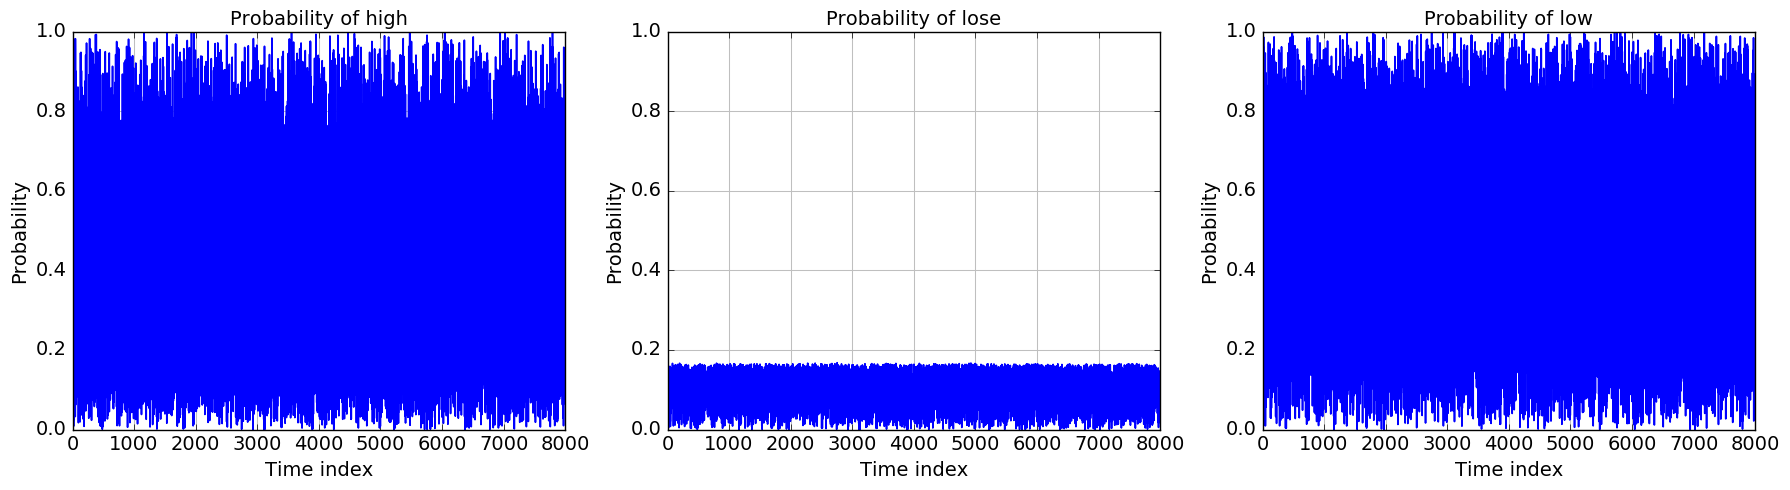

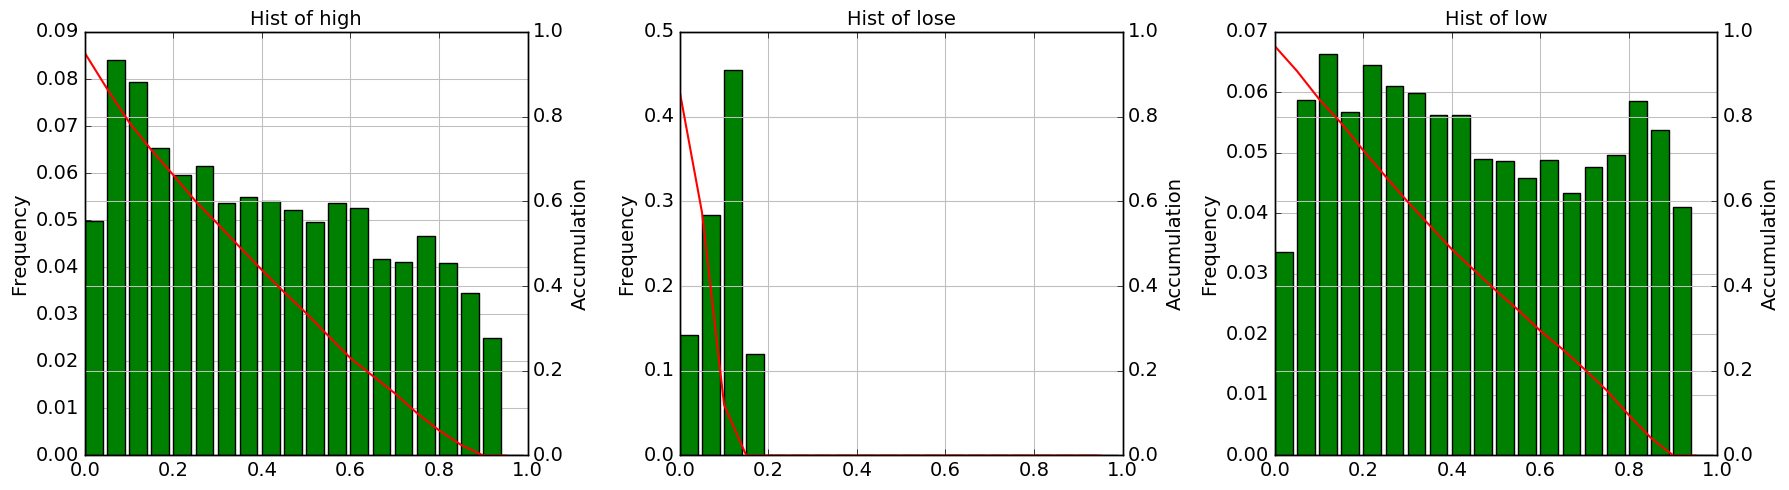

In [67]:
# 各ラベルに該当する確率
dff.makefig(18, 5)
for ii in range(len(probs)):
    plt.subplot(1,3,ii + 1)
    plt.plot(probs[ii], linewidth=1.2)
    dff.arrangefig(xlabel="Time index", ylabel="Probability", title="Probability of {}".format(labels[ii]))
    plt.ylim(0, 1)
plt.tight_layout()

# 各ラベルに該当する確率のヒストグラム
dff.makefig(18, 5)
dxbins = np.diff(xbins)[0]
for ii in range(len(hists)):
    plt.subplot(1,3,ii + 1)
    plt.bar(xbins, hists[ii], width=0.8*dxbins, hold="center", color="g")
    dff.arrangefig(ylabel="Frequency")
    ax2 = plt.gca().twinx()
    ax2.plot(xbins, 1.0 - np.cumsum(hists[ii]), "r-", linewidth=1.5)
    dff.arrangefig(xlabel="Probability", ylabel="Accumulation", title="Hist of {}".format(labels[ii]))
    plt.ylim(0, 1)
#     plt.yscale("log")
plt.tight_layout()

In [69]:
prob_threshold = 0.75
probs = model.predict_proba(X_test, verbose=0).T
inds = np.zeros_like(probs, dtype=bool)
for ii in range(0, probs.shape[0]):
    inds[ii] = probs[ii] >= prob_threshold
ind_sum = inds.sum(axis=0) > 0
print("<# of events over threshold>")
print("[high, lose, low]:", inds.sum(axis=1), 
      ",total:", ind_sum.sum(),
      ", percentage:{0:.1f}".format(ind_sum.sum()*100./len(X_test)))

# # テストデータを用いて評価する --- (※6)
score = model.evaluate(X_test[ind_sum], y_test[ind_sum], verbose=0)
print('loss=', score[0])
print('accuracy=', score[1])

<# of events over threshold>
[high, lose, low]: [1269    0 1782] ,total: 3051 , percentage:38.2
loss= 0.43576730778
accuracy= 0.874467387742


## まとめ
SMAにHLを加えることで、SMAだけの場合に比べてさらに確率が上がるようである。   
あとは欠損データをどうするかとか、前のデータいくつ分までを時系列データとして取り入れるかなど、いくつか検討したいことがある。   
ひとまず、何度かテストデータを変えてみて、今のモデルで確率を計算した後にバックテストに移ろうと思う。

## データの保存

In [113]:
import json
import h5py
import os
from keras.models import Sequential

class KerasModelAdapter(object):
    def __init__(self, model=None):
        self.__model = model
    
    def model(self):
        return self.__model
    
    def save(self, fldrpath):
        """
        Save the whole information on the model
        """
        if not os.path.exists(fldrpath):
            os.makedirs(fldrpath)
        
        # Save the model architecture
        model = self.__model
        model_json_str = model.to_json()
        with open(fldrpath + "model.json", 'w') as ff:
            ff.write(model_json_str)
            
        # Save the learned weights
        model.save_weights(fldrpath + "weights.h5")
        
        # Save the information on compilation
        loss_name = model.loss
        opt_name = model.optimizer.__class__.__name__.split(".")[-1].lower()
        metrics_list = model.metrics
        compile_info = {"loss":loss_name, "optimizer":opt_name, "metrics":metrics_list}
        with open(fldrpath + 'compile_info.json','w') as ff:
            json.dump(compile_info, ff)

    def load(self, fldrpath):
        """
        Load and generate the model from the files in `fldrpath`.
        """
        # Load the model architecture
        model = model_from_json(open(fldrpath + "model.json", "r").read())

        # Load the learned weights
        model.load_weights(fldrpath + "weights.h5")

        # Load the information on compilation
        with open(fldrpath + 'compile_info.json','r') as ff:
            compile_info = json.load(ff)
        model.compile(loss=compile_info["loss"],
            optimizer=compile_info["optimizer"],
            metrics=compile_info["metrics"])
        self.__model = model

In [103]:
adapter = KerasModelAdapter(model)

In [104]:
adapter.save("./data/model_20170530/")

In [114]:
adapter2 = KerasModelAdapter()
adapter2.load("./data/model_20170530/")

In [115]:
model2 = adapter2.model()

In [116]:
prob_threshold = 0.75
probs = model2.predict_proba(X_test, verbose=0).T
inds = np.zeros_like(probs, dtype=bool)
for ii in range(0, probs.shape[0]):
    inds[ii] = probs[ii] >= prob_threshold
ind_sum = inds.sum(axis=0) > 0
print("<# of events over threshold>")
print("[high, lose, low]:", inds.sum(axis=1), 
      ",total:", ind_sum.sum(),
      ", percentage:{0:.1f}".format(ind_sum.sum()*100./len(X_test)))

# # テストデータを用いて評価する --- (※6)
score = model2.evaluate(X_test[ind_sum], y_test[ind_sum], verbose=0)
print('loss=', score[0])
print('accuracy=', score[1])

<# of events over threshold>
[high, lose, low]: [1269    0 1782] ,total: 3051 , percentage:38.2
loss= 0.43576730778
accuracy= 0.874467387742
